# Synthetic data
This notebook is used for generating synthetic time series for experiments. 

In [1]:
#| export
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from typing import List, Tuple

### Configurations and utilities

In [2]:
#| export
synthetic_data_path = os.path.join(os.path.expanduser('~'), 'data', 'synthetic_data')
os.makedirs(synthetic_data_path, exist_ok=True)

In [3]:
#| export
def generate_ts(periods              : int = 60*24*7, 
                start_date           : str = '2022-01-01 00:00',
                index_offset         : int = 0,
                hourly_factors       : List[float] = [1]*7,
                hourly_initial_phase : List[float] = None,
                daily_factor         : float = 1,
                daily_init_phase     : float = 0,
                weekly_factor        : float = 1,     
                weekly_init_phase    : float = 0,  
                noise_sd             : float = 1,
                ts_offset            : float = 0,
                trend                : float = 0,
               ) -> pd.DataFrame:
    """
    Generates a synthetic time series with hourly, daily, and weekly seasonal patterns, 
    along with optional noise, trend, and offset adjustments.

    Parameters:
    -----------
    periods : int, default=60*24*7
        Number of time intervals to generate, representing the total length of the series.
    start_date : str, default='2022-01-01 00:00'
        Start date and time for the time series.
    index_offset : int, default=0
        Starting offset for the time index, which shifts the phase of all components.
    hourly_factors : List[float], default=[1]*7
        Amplitude factors for each hourly frequency group (1, 2, 3, 4, 6, 8, 12 hours).
    hourly_initial_phase : List[float], default=None
        Initial phase shifts for each hourly frequency group, affecting the sine wave starting points.
    daily_factor : float, default=1
        Amplitude factor for the daily (24-hour) component.
    daily_init_phase : float, default=0
        Initial phase shift for the daily component.
    weekly_factor : float, default=1
        Amplitude factor for the weekly (7-day) component.
    weekly_init_phase : float, default=0
        Initial phase shift for the weekly component.
    noise_sd : float, default=1
        Standard deviation for the Gaussian noise added to the series.
    ts_offset : float, default=0
        Constant offset applied to the entire time series.
    trend : float, default=0
        Linear trend factor added to the series, causing a constant increase or decrease over time.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the generated time series components, seasonal patterns, 
        and the final series with optional noise and trend.
    """
    # Parameters
    minutes_per_hour = 60
    hourly_groups = [1, 2, 3, 4, 6, 8, 12]
    hourly_phase = hourly_initial_phase or [0]*7
    
    # Frequences for detecting cycles
    hourly_freq = (2*np.pi)/(minutes_per_hour)
    daily_freq  = (2*np.pi)/(minutes_per_hour*24)
    weekly_freq = (2*np.pi)/(minutes_per_hour*24*7)

    # Index
    index = pd.date_range(
        start=start_date, 
        periods=periods, 
        freq='1min', 
        name='Timestamp'
    )
    x  = np.arange(index_offset, index_offset + len(index))
    df = pd.DataFrame(index=index)
    
    # Hour component
    for n, f, init_phase in zip(hourly_groups, hourly_factors, hourly_phase):
        df[f'{n} hours component'] = f * np.sin(((1/n) * hourly_freq * x) + init_phase)
    # Different components
    df['Hourly component'] = df.sum(axis=1)
    df['Daily component']  = daily_factor * np.sin((daily_freq * x) + daily_init_phase)
    df['Weekly component'] = weekly_factor * np.sin((weekly_freq * x) + weekly_init_phase)
    df['Noise'] = np.random.normal(scale=noise_sd, size=len(x))
    # Toguether without noise or trend
    df['Seasonal time series'] = df['Hourly component'] \
                                 + df['Daily component'] \
                                 + df['Weekly component'] \
                                 + ts_offset
    # Add noise
    df['Seasonal time series w/ noise'] = df['Seasonal time series'] + df['Noise']
    # Add trend
    if trend:
        df['Seasonal time series w/ noise and trend'] = df['Seasonal time series w/ noise'] + trend * x
    
    return df

In [4]:
#| export
def plot_ts_components(
    df              : pd.DataFrame,
    resampling_freq : str = None,
    figsize         : Tuple[float,float] = (20,10),
    title           : str = None,
    verbose         : int = 0
) -> None : 
    
    fig, axes = plt.subplots(4,1,figsize=figsize, sharex=True)
    
    h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]
    all_colors = ['blue','orange','green','red','purple','brown','gray']  # f'tab:{c}'
    
    df.iloc[:,h_index].plot(ax=axes[0], color=[f'tab:{all_colors[i]}' for i in h_index])
            
    df.iloc[:,7:10].plot(ax=axes[1], color=['yellowgreen', 'mediumseagreen', 'gold'])
    df.iloc[:,11].plot(ax=axes[2], color='skyblue')
    if resampling_freq:
        if verbose > 0: 
            print(f"plot_ts_components | Resample | original size: {df.shape}" )
        ts = df.iloc[:,-1].resample(resampling_freq).mean()
        ts = ts.rename(f'Resampled time series w/ noise [resampling_freq:{resampling_freq}]')
        ts.plot(ax=axes[3], color='mediumvioletred')
        if verbose > 0: 
            print(f"plot_ts_components | Resample | final size: {ts.shape}" )
    else:
        df.iloc[:,-1].plot(ax=axes[3], color='mediumvioletred')

    for ax in axes:
        ax.grid(which='both', axis='x')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, .8*box.height])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
                  fancybox=True, shadow=True, ncol=7)
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9, hspace=0.4)
    plt.show()


## Synthetic Data - Clusters

### Clusters I

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


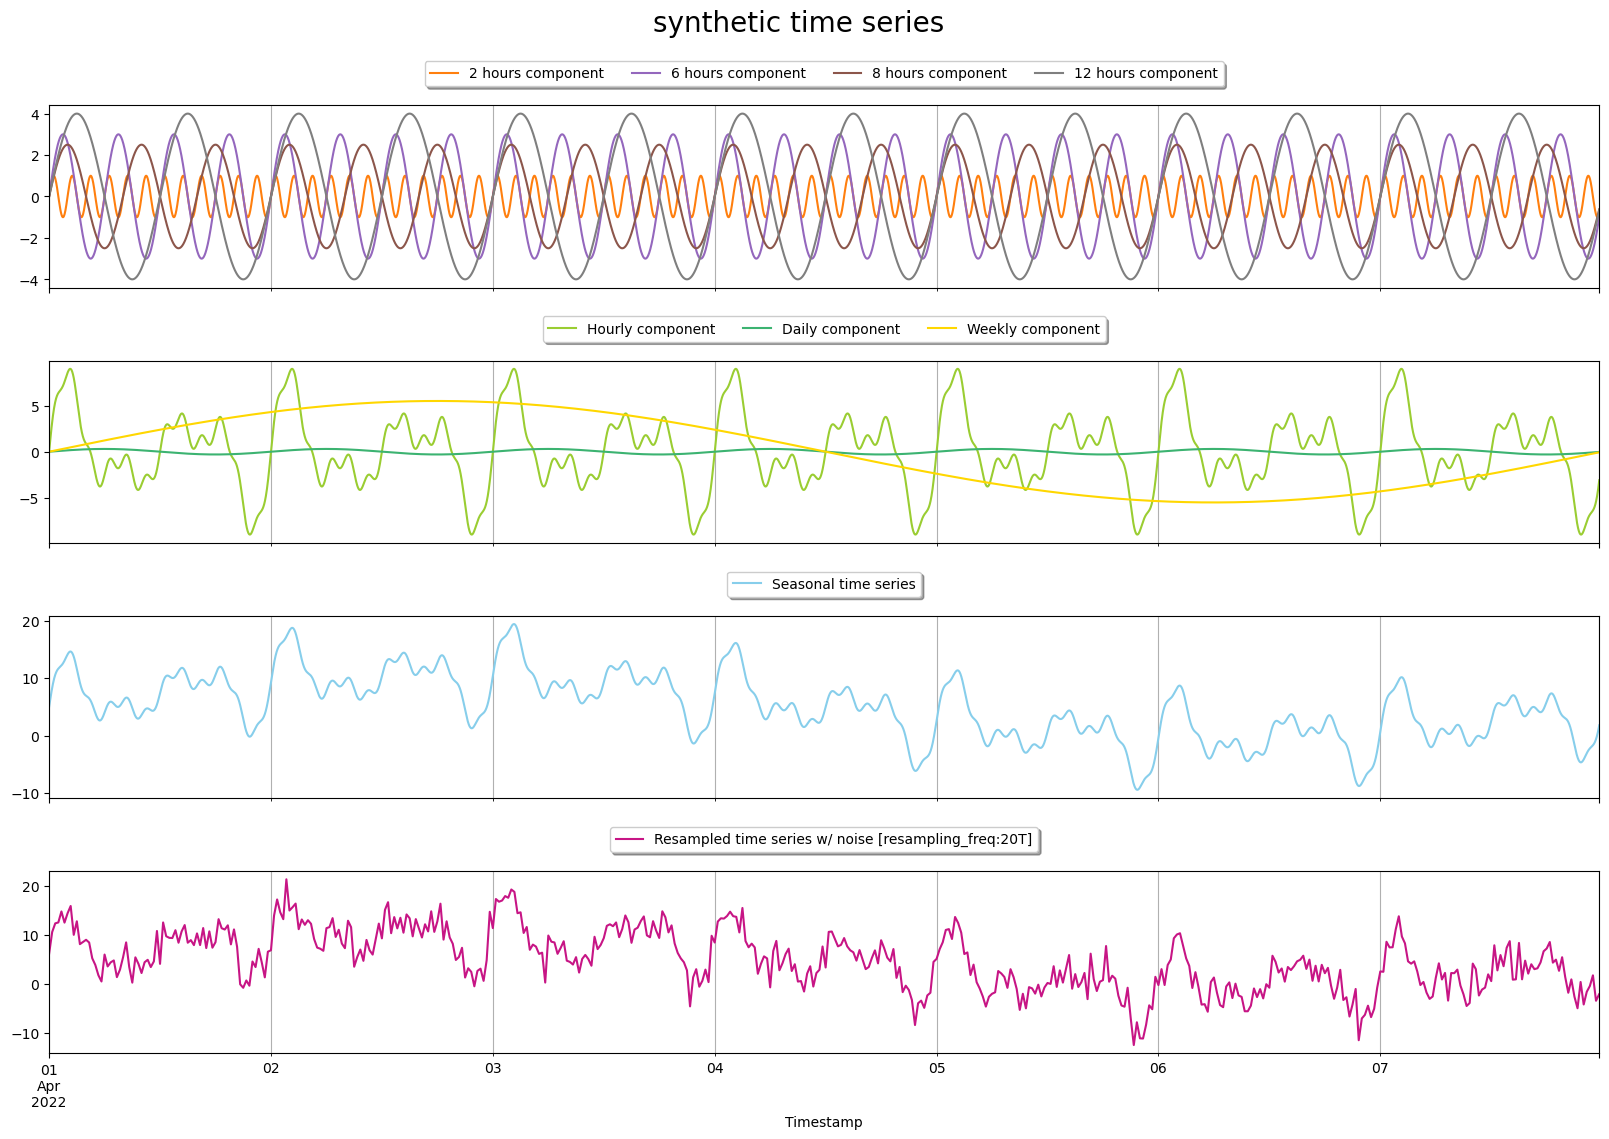

In [5]:
#| export
df = generate_ts(periods=60*24*7, start_date='2022-04-01 00:00', index_offset=0,
                  hourly_factors=[0, 1, 0, 0, 3, 2.5, 4], daily_factor=0.3,
                  weekly_factor=5.5, noise_sd=10, ts_offset=5)
plot_ts_components(df, figsize=(20,12), title='synthetic time series', 
                   resampling_freq='20T')

### Clusters II

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


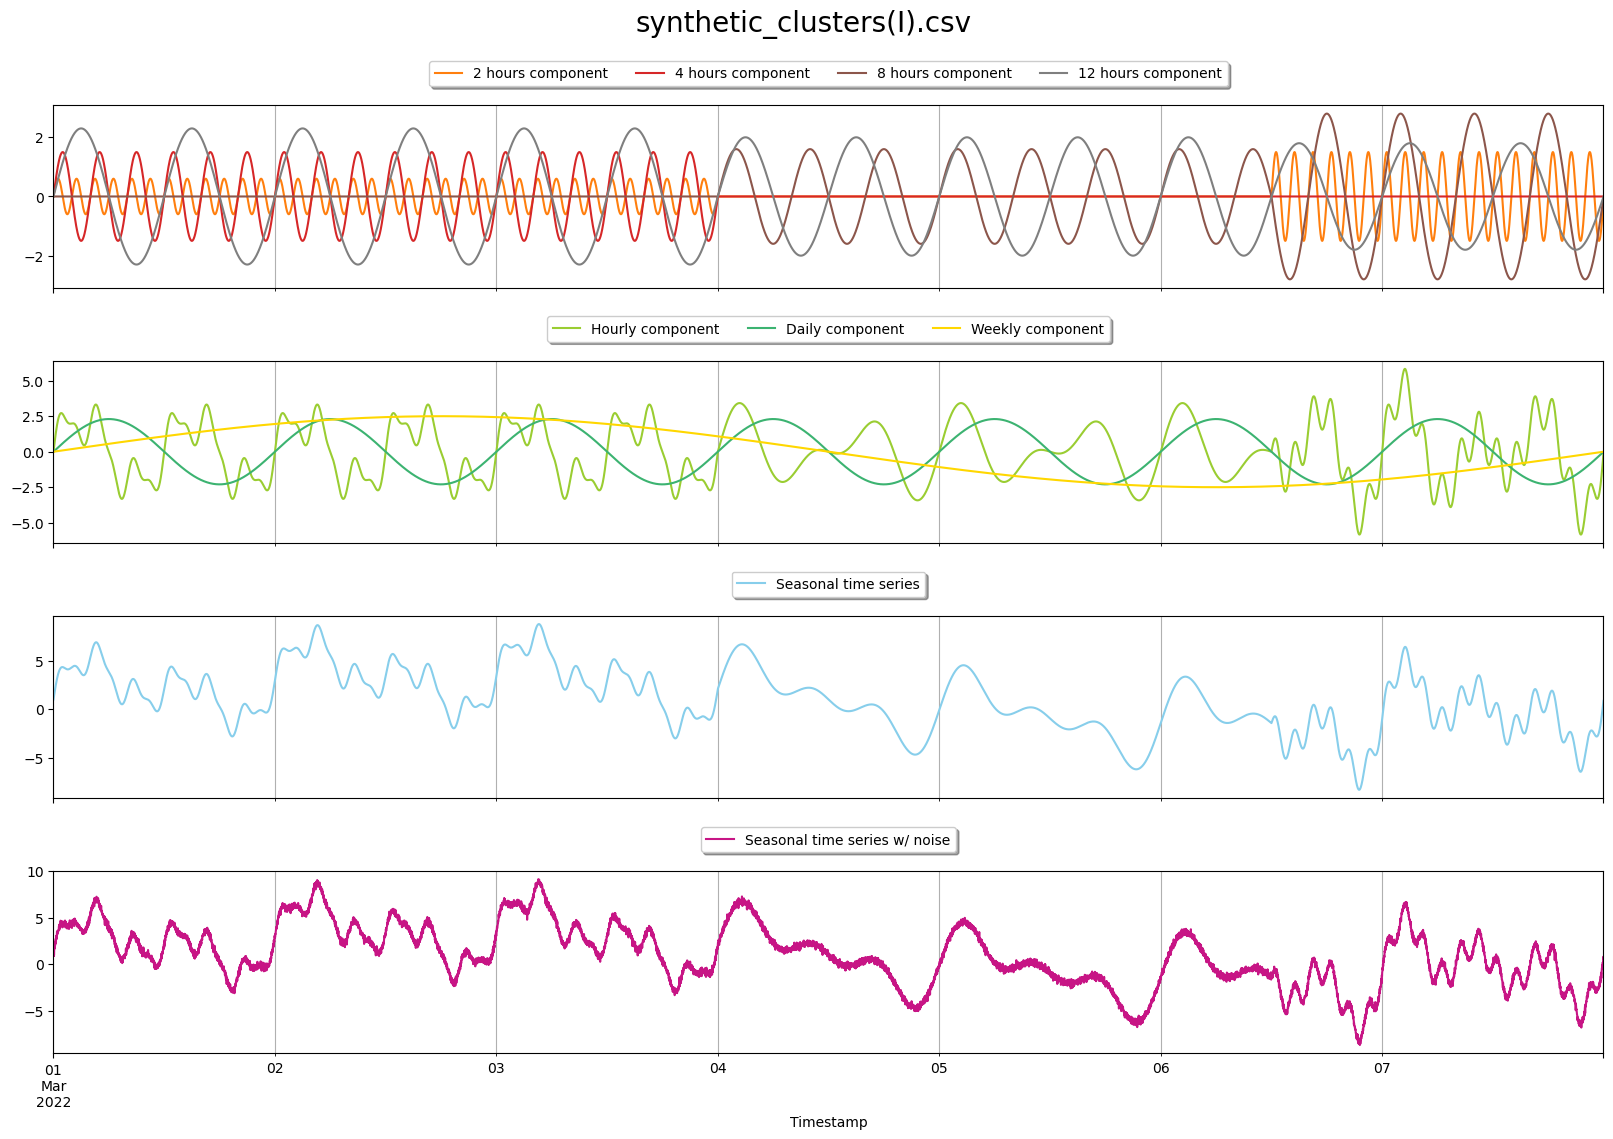

10080

In [6]:
#| export
df1 = generate_ts(periods=60*24*3, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0.6, 0, 1.5, 0, 0, 2.3], daily_factor=2.3, 
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df2 = generate_ts(periods=60*24*2.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 0, 0, 1.6, 2], daily_factor=2.3,
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df3 = generate_ts(periods=60*24*1.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1.5, 0, 0, 0, 2.8, 1.8], daily_factor=2.3, 
                  weekly_factor=2.5, noise_sd=0.2, ts_offset=1)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
#df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

### Clusters III

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


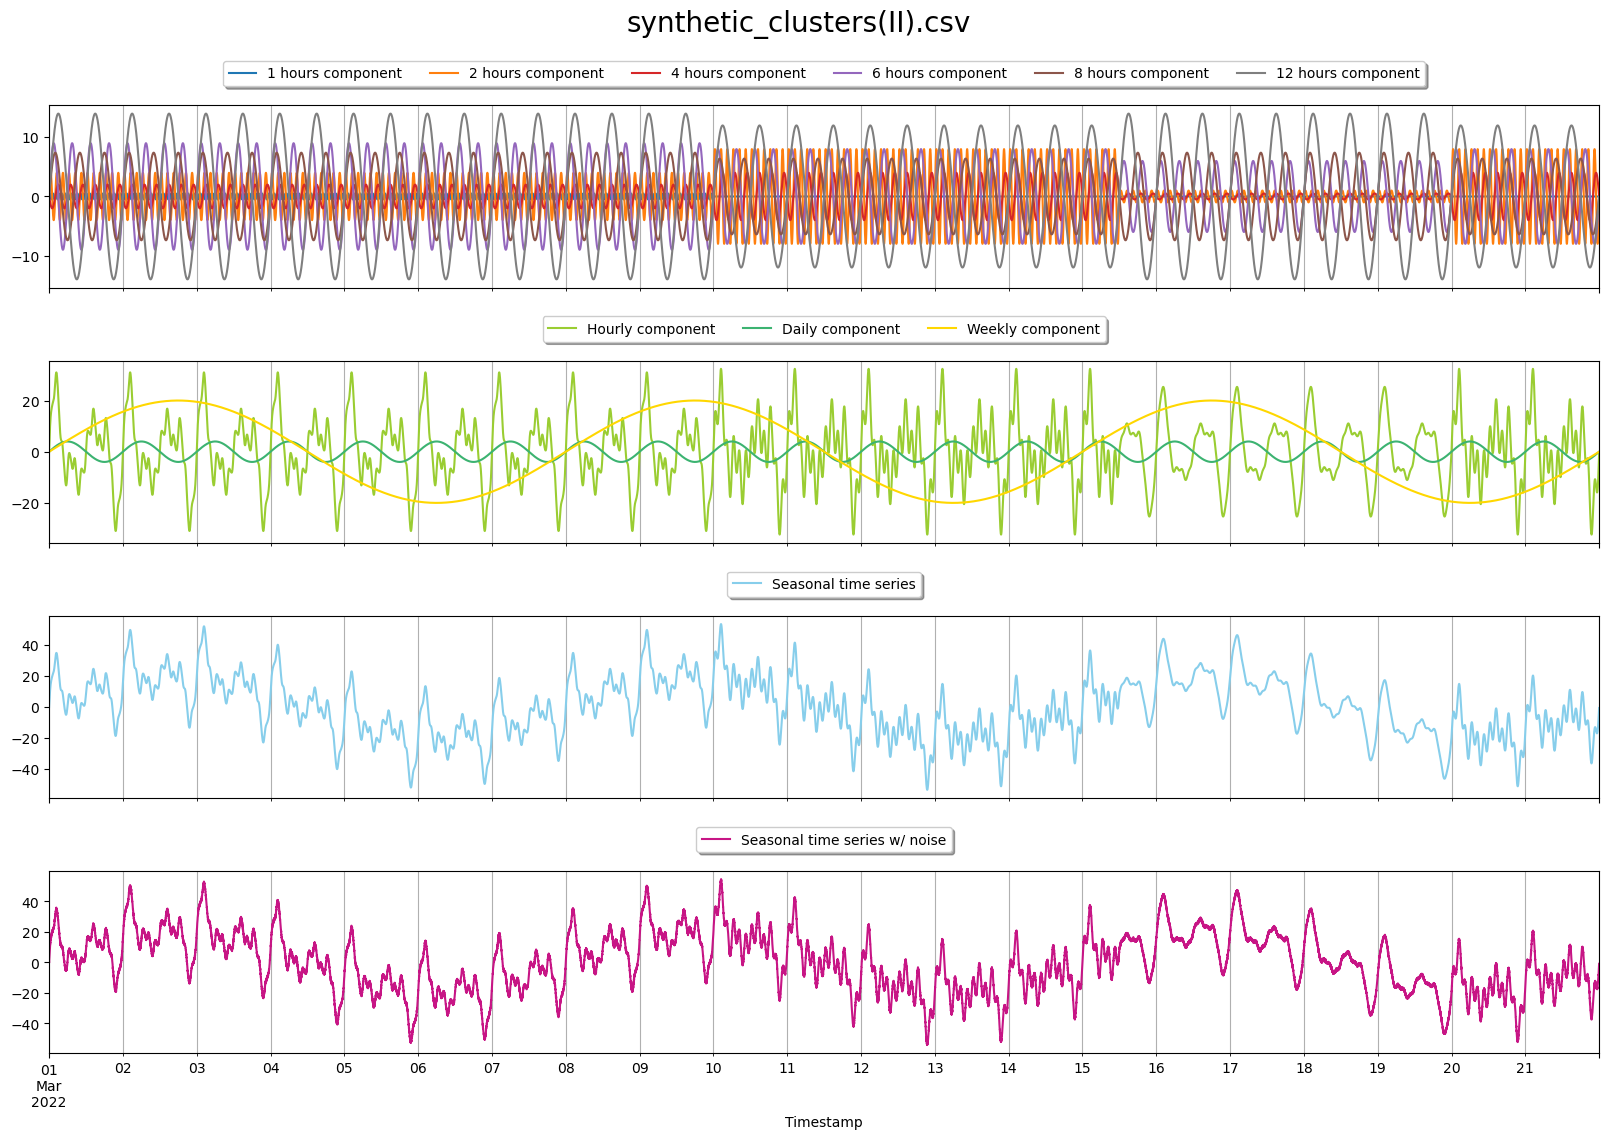

30240

In [7]:
#| export
df1 = generate_ts(periods=60*24*9, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0.5, 4, 0, -2, 9, 7.4, 14], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df2 = generate_ts(periods=60*24*5.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 8, 0, -4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df3 = generate_ts(periods=60*24*4.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1, 0, -0.5, 6, 7.4, 14], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df4 = generate_ts(periods=60*24*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 8, 0, -4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=20, noise_sd=0.4)

df = pd.concat([df1,df2,df3,df4])
time_series_name = 'synthetic_clusters(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

### Clusters III

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


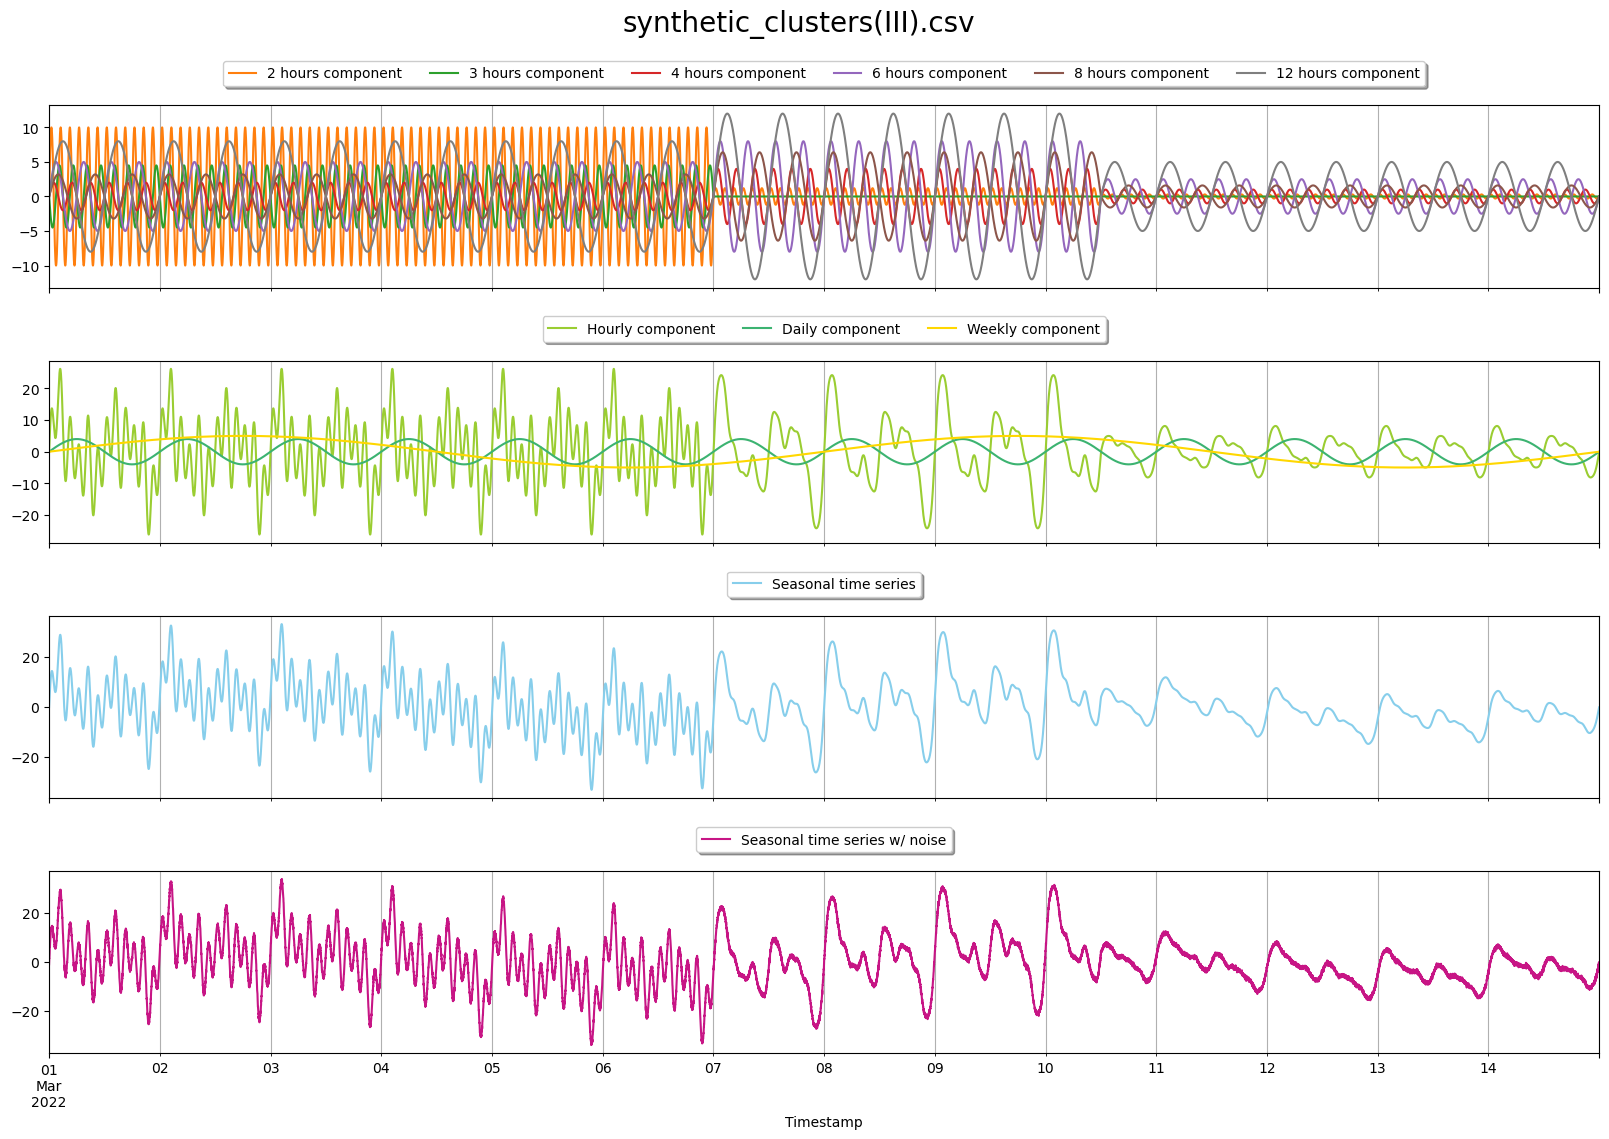

20160

In [8]:
#| export
df1 = generate_ts(periods=60*24*6, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 10, -4.5, 2, 5, 3.2, 8], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df2 = generate_ts(periods=60*24*3.5, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 1.2, 0, 4, 8, 6.4, 12], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df3 = generate_ts(periods=60*24*4.5, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0.3, 0, 1, 2.5, 1.6, 5], 
                  daily_factor=4, weekly_factor=5, noise_sd=0.4)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(III).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

### Clusters IV

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


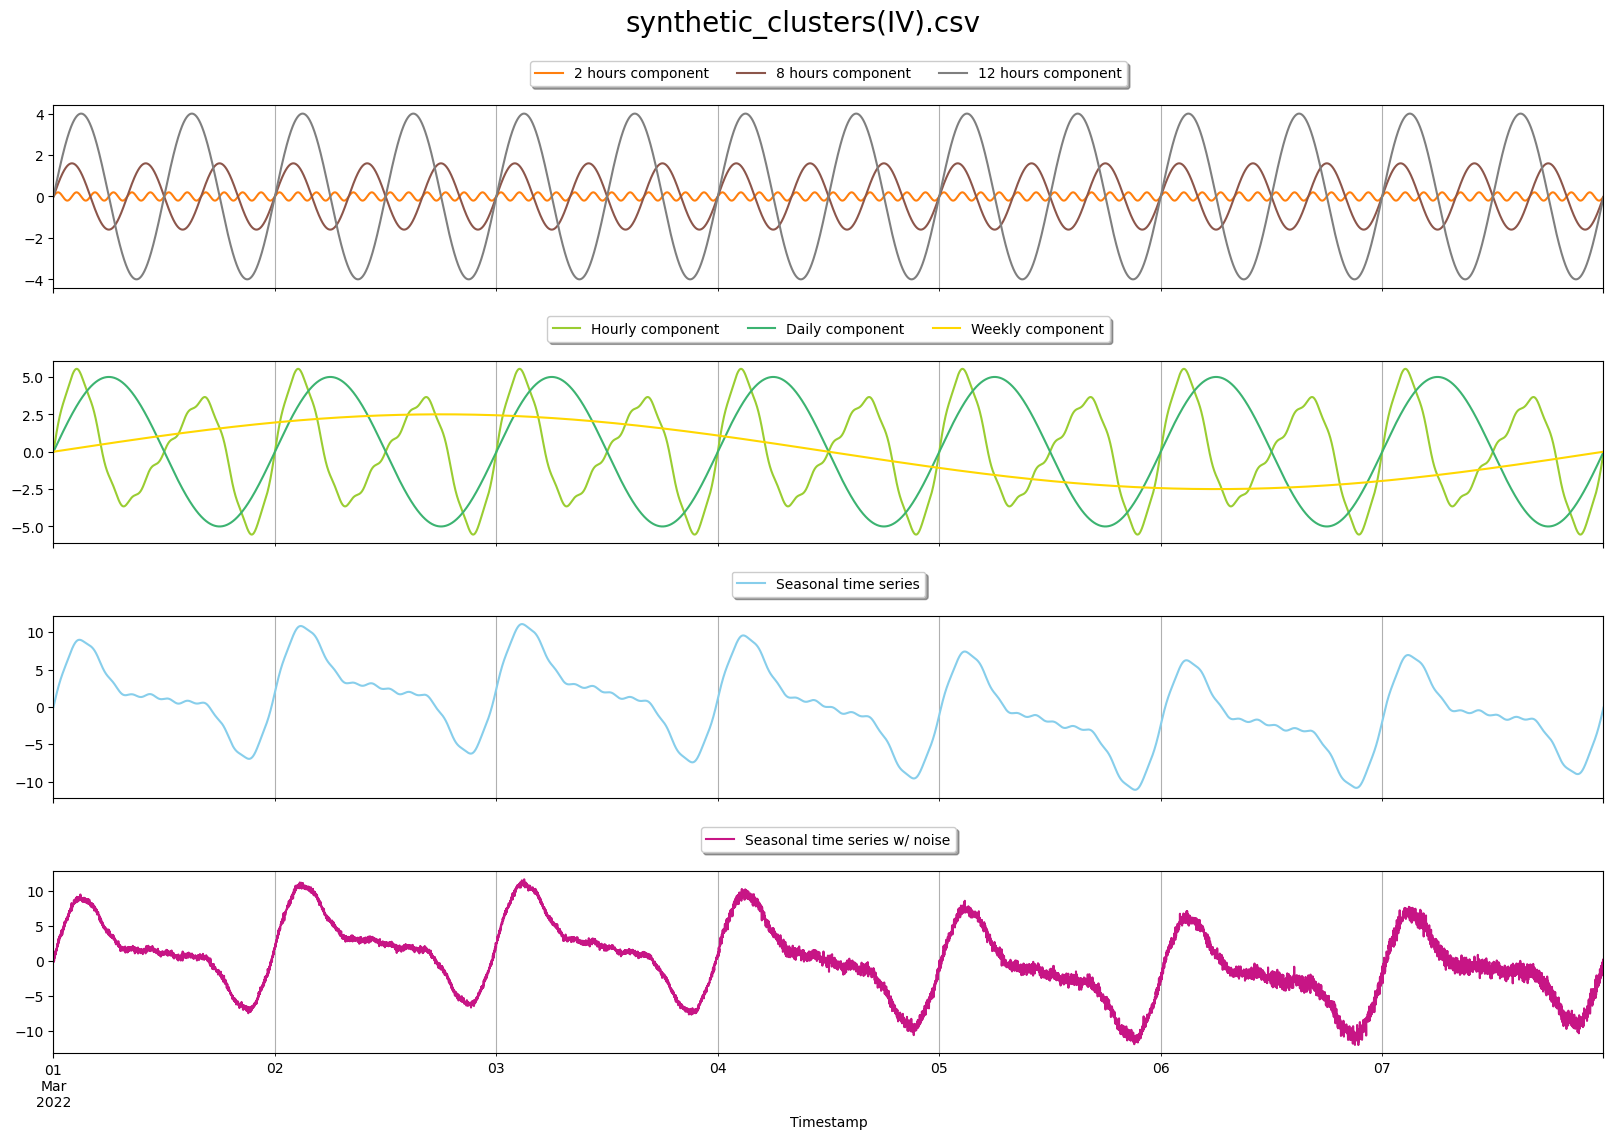

10080

In [9]:
#| export
df1 = generate_ts(
    periods       = 60*24*3, 
    start_date    = '2022-03-01 00:00', 
    index_offset  = 0,
    hourly_factors= [0, 0.2, 0, 0, 0, 1.6, 4], 
    daily_factor  = 5, 
    weekly_factor = 2.5, 
    noise_sd      = 0.2
)

df2 = generate_ts(
    periods       = 60*24*2.5, 
    index_offset  = len(df1), 
    start_date    = str(df1.index[-1] + pd.offsets.Minute()), 
    hourly_factors= [0, 0.2, 0, 0, 0, 1.6, 4], 
    daily_factor  = 5, 
    weekly_factor = 2.5, 
    noise_sd      = 0.4
)

df3 = generate_ts(
    periods       = 60*24*1.5, 
    index_offset  = len(df1)+len(df2),
    start_date    = str(df2.index[-1] + pd.offsets.Minute()),
    hourly_factors= [0, 0.2, 0, 0, 0, 1.6, 4], 
    daily_factor  = 5, 
    weekly_factor = 2.5, 
    noise_sd      = 0.6
)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_clusters(IV).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

## Synthetic Data - Segmentation
### Segmentation I

> 🗣️ **S1:**  
> ────────────────────────────────────────  
> *Univariate time series spanning 24 days of data, made up of four segments of respective size 7.5, 6.5, 10, and 4 days, with different patterns constructed by varying the amplitudes of the different seasonal components. More specifically, two of them, the first and the third, maintain the same components with seasonality less than a day, and only the components with a daily and weekly seasonality vary, maintaining a very similar daily pattern in both segments.*  
> ────────────────────────────────────────  
>
> [DeepVATS: Deep Visual Analytics for Time Series](https://www.sciencedirect.com/science/article/pii/S0950705123005439)

The generator below builds the synthetic time series as goes:

#### First segment (df1): 
- Starts in '2022-03-01 00:00'
- Size: 7.5 days = 7.5*24*60 min = 10800 min
- Periods: 10800 periods of 1 min

In [10]:
#| export
df1 = generate_ts(
    periods       = 60*24*7.5,                   # Segment length
    start_date    = '2022-03-01 00:00',          # First index in the dataset
    index_offset  = 0,                           # First index of the segment
    hourly_factors= [0, 0.6, 0, 1.5, 0, 0, 2.3], # "Importance" of each hour group (1,2,...,12)
    daily_factor  = 2.3,                         # Daily amplitude 
    weekly_factor = 2.5,                         # Weekly amplitude
    noise_sd      = 2,                           # Moderate noise
    ts_offset     = 1                            # Move time series up to start in 1
)

In [11]:
#| hide
print(f"df1~{df1.shape}, id[{df1.index[0]}, {df1.index[-1]}], total: {df1.index[-1]-df1.index[0]}")

df1~(10800, 13), id[2022-03-01 00:00:00, 2022-03-08 11:59:00], total: 7 days 11:59:00


#### Second segment (df2): 
- Size: 6.5 d = 6.5*24 h = 156 h
- Periods: 60*156 = 9360 => 9630 periods of 1 min

In [12]:
#| export
df2 = generate_ts(
    periods       = 60*24*6.5,
    index_offset  = len(df1),                                  # Add df2 after df1
    start_date    = str(df1.index[-1] + pd.offsets.Minute()),  # Add df2 after df1 (start 1 minute after)
    hourly_factors= [0, 1.5, 0, 1.5, 0, 0, 2.3],               # Hours relevance
    daily_factor  = 2.3,                                       # Daily amplitude
    weekly_factor = 1.5,                                       # Week amplitude
    noise_sd      = 4,                                         # Noise deviation 
    ts_offset     = 1                                          # 1 position up in y axis!
)

In [13]:
#| hide
print(f"df2~{df2.shape}, id[{df2.index[0]}, {df2.index[-1]}], total: {df2.index[-1]-df2.index[0]}")

df2~(9360, 13), id[2022-03-08 12:00:00, 2022-03-14 23:59:00], total: 6 days 11:59:00


#### Third segment (df3):
- Size: 10 d = 240 h
- Periods: 14400 periods of 1 min

In [14]:
#| export
df3 = generate_ts(
    periods       = 60*24*10, 
    index_offset  = len(df1)+len(df2),
    start_date    = str(df2.index[-1] + pd.offsets.Minute()), 
    hourly_factors= [0, 0.6, 0, 1.5, 0, 0, 2.3], 
    daily_factor  = 3, 
    weekly_factor = 5, 
    noise_sd      = 2, 
    ts_offset     = 1
)

In [15]:
#| hide
print(f"df3~{df3.shape}, id[{df3.index[0]}, {df3.index[-1]}], total: {df3.index[-1]-df3.index[0]}")

df3~(14400, 13), id[2022-03-15 00:00:00, 2022-03-24 23:59:00], total: 9 days 23:59:00


#### Fourth segment (df4):
- Size: 4d = 96h
- Periods: 5760 h = 240 d

In [16]:
#| export
df4 = generate_ts(
    periods       = 60*24*4, 
    index_offset  = len(df1)+len(df2)+len(df3),
    start_date    = str(df3.index[-1] + pd.offsets.Minute()), 
    hourly_factors= [0, 0.6, 0, 0.5, 0, 0, 4.3], daily_factor=1, 
    weekly_factor = 2, 
    noise_sd      = 3, 
    ts_offset     = 1
)

In [17]:
#| hide
print(f"df4~{df4.shape}, id[{df4.index[0]}, {df4.index[-1]}], total: {df4.index[-1]-df4.index[0]}")

df4~(5760, 13), id[2022-03-25 00:00:00, 2022-03-28 23:59:00], total: 3 days 23:59:00


In [18]:
#| export
df = pd.concat([df1,df2,df3,df4])
print(f"df~{df.shape}, id[{df.index[0]}, {df.index[-1]}], total: {df.index[-1]-df.index[0]}")

df~(40320, 13), id[2022-03-01 00:00:00, 2022-03-28 23:59:00], total: 27 days 23:59:00


In [19]:
df.index.freq

<Minute>

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


plot_ts_components | Resample | original size: (40320, 13)
plot_ts_components | Resample | final size: (2016,)


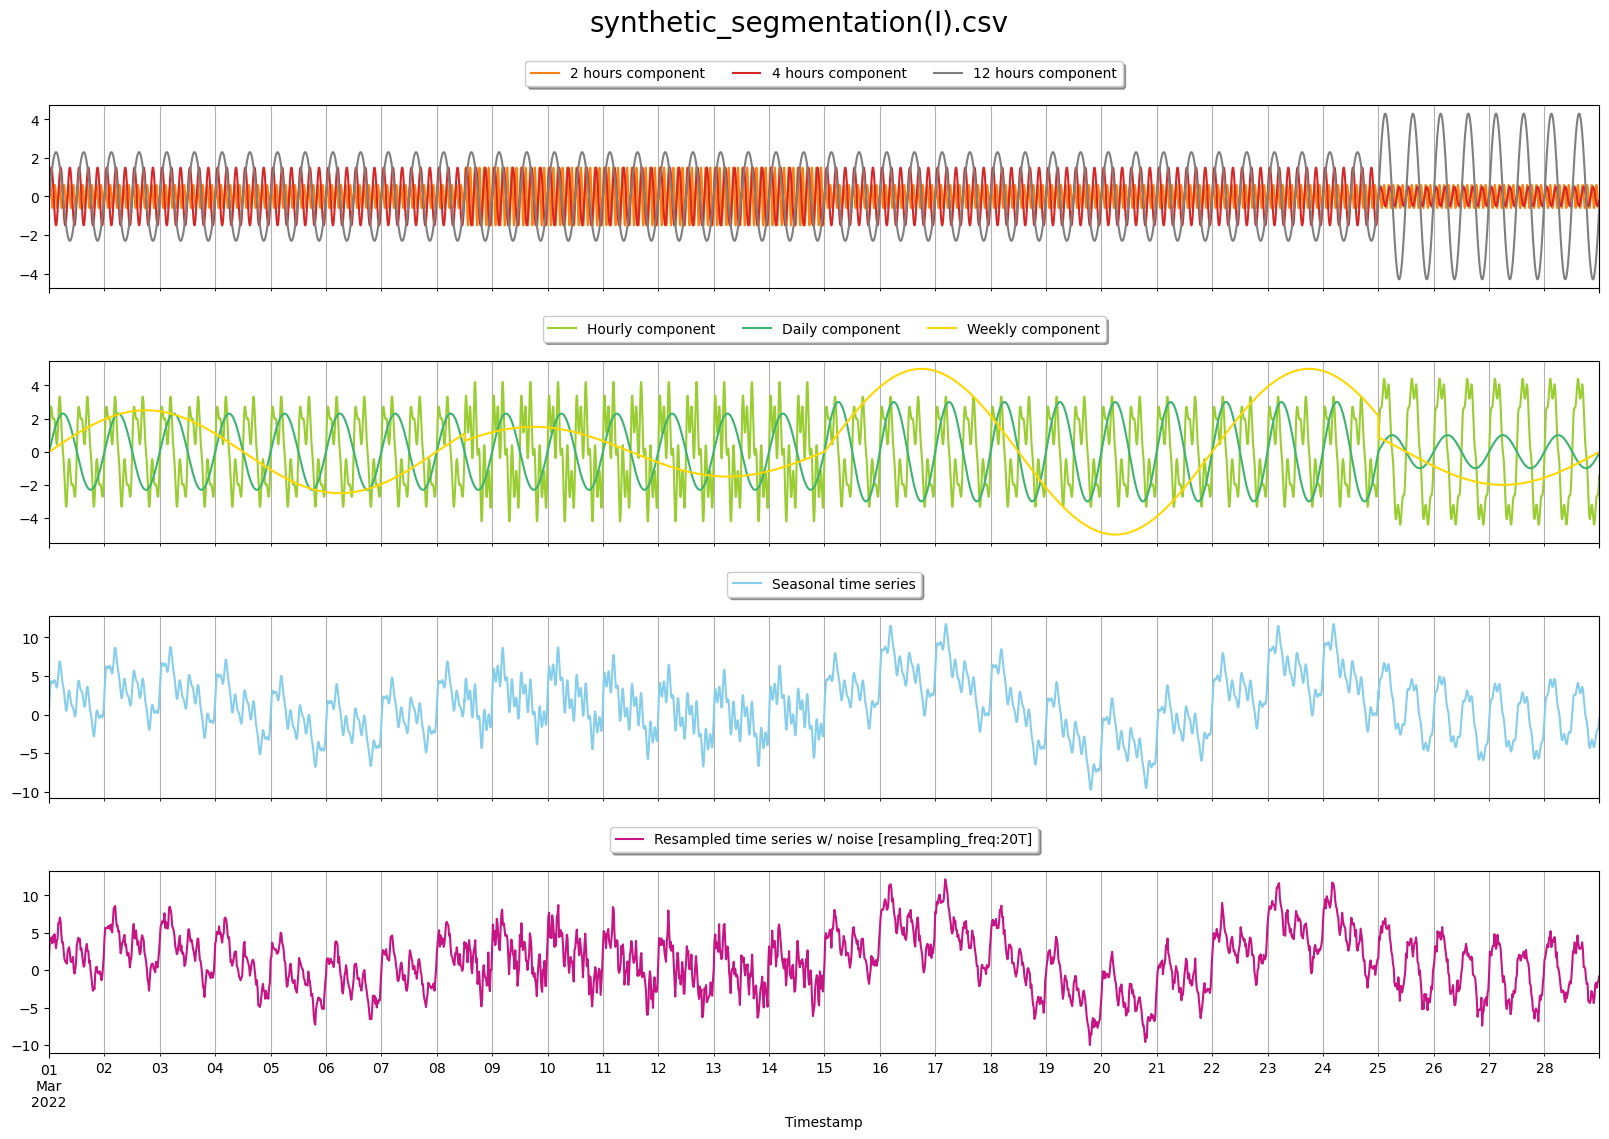

In [20]:
time_series_name = 'synthetic_segmentation(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='20T', verbose = 1)
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))

In [21]:
len(df.columns)

13

In [22]:
df.columns[12]

'Seasonal time series w/ noise'

> 📝 **Note on S1**:
>
> ────────────────────────────────────────
> 
> Take care with two details: 
> 
> 1) They are 28 days in total
> 2) The final time series is resampled by taking means of each 20 minutes groups (frequency factor: 20)
>   
> ────────────────────────────────────────  


## Synthetic Data - Outliers
### Outliers I

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


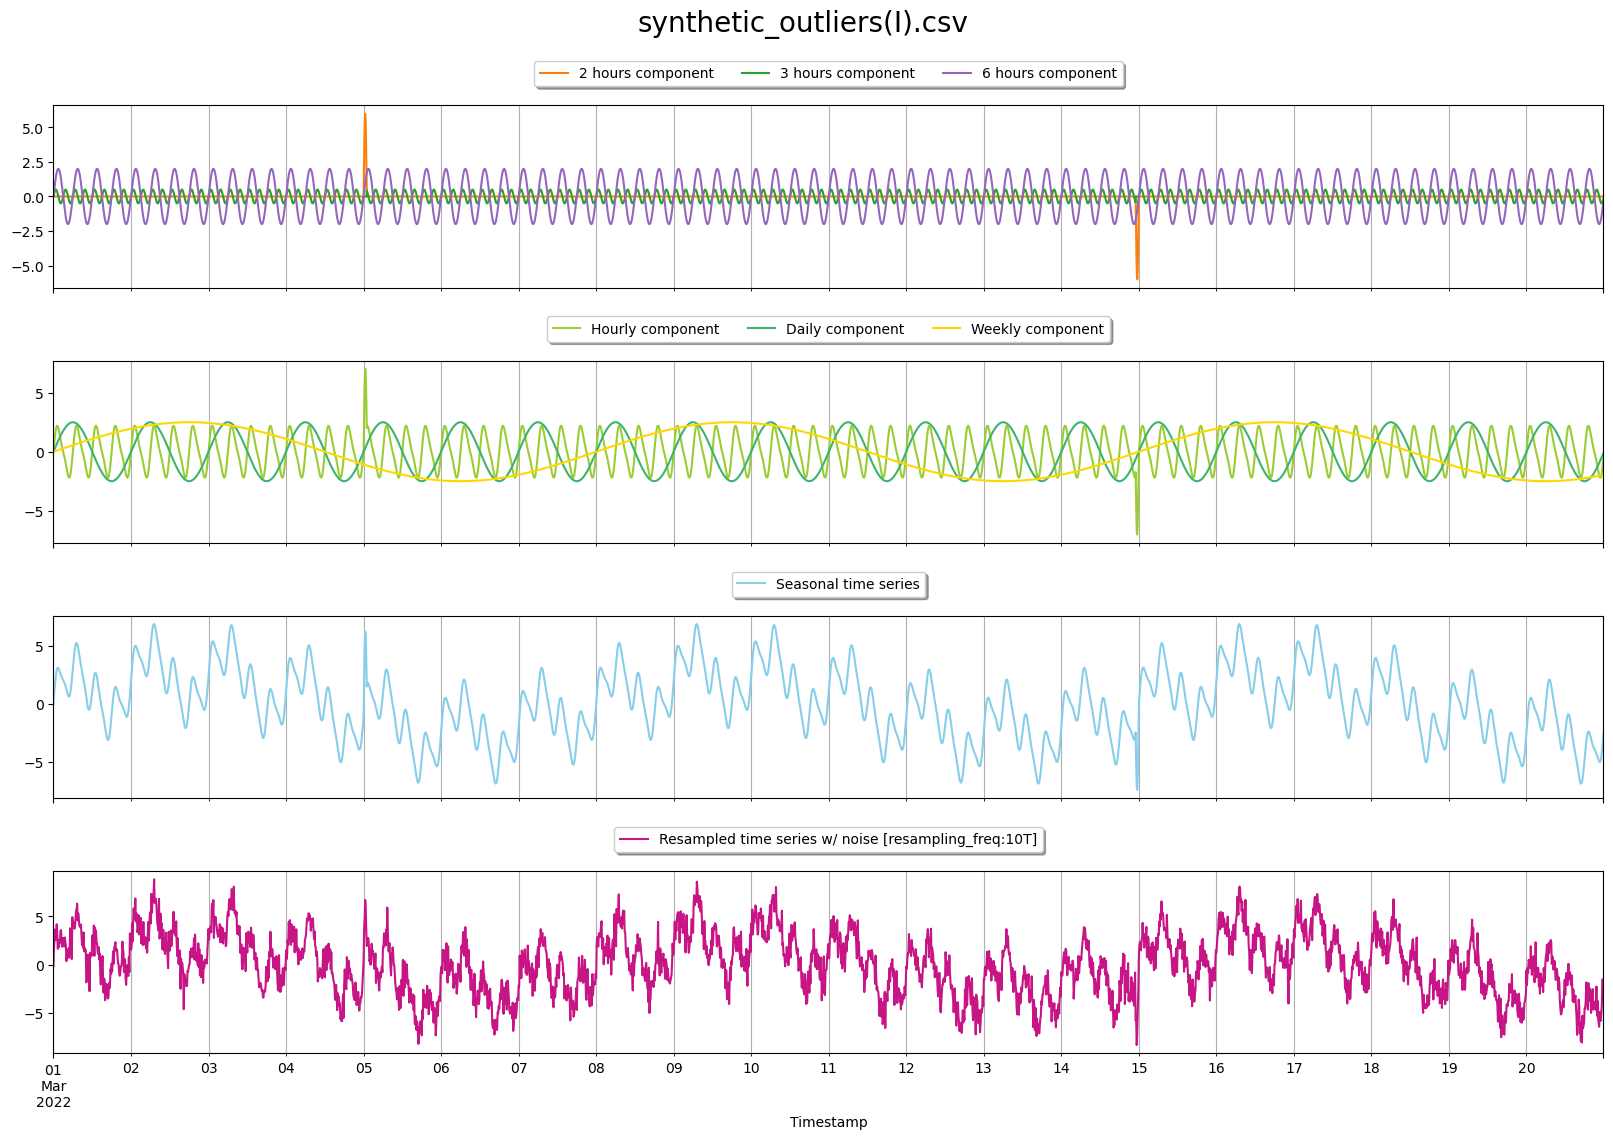

28800

In [23]:
#| export
sd = 3
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 6, 0, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-120, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 6, 0, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2.5, 
                  weekly_factor=2.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='10T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

In [24]:
len(df.columns)

13

### Outliers II

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


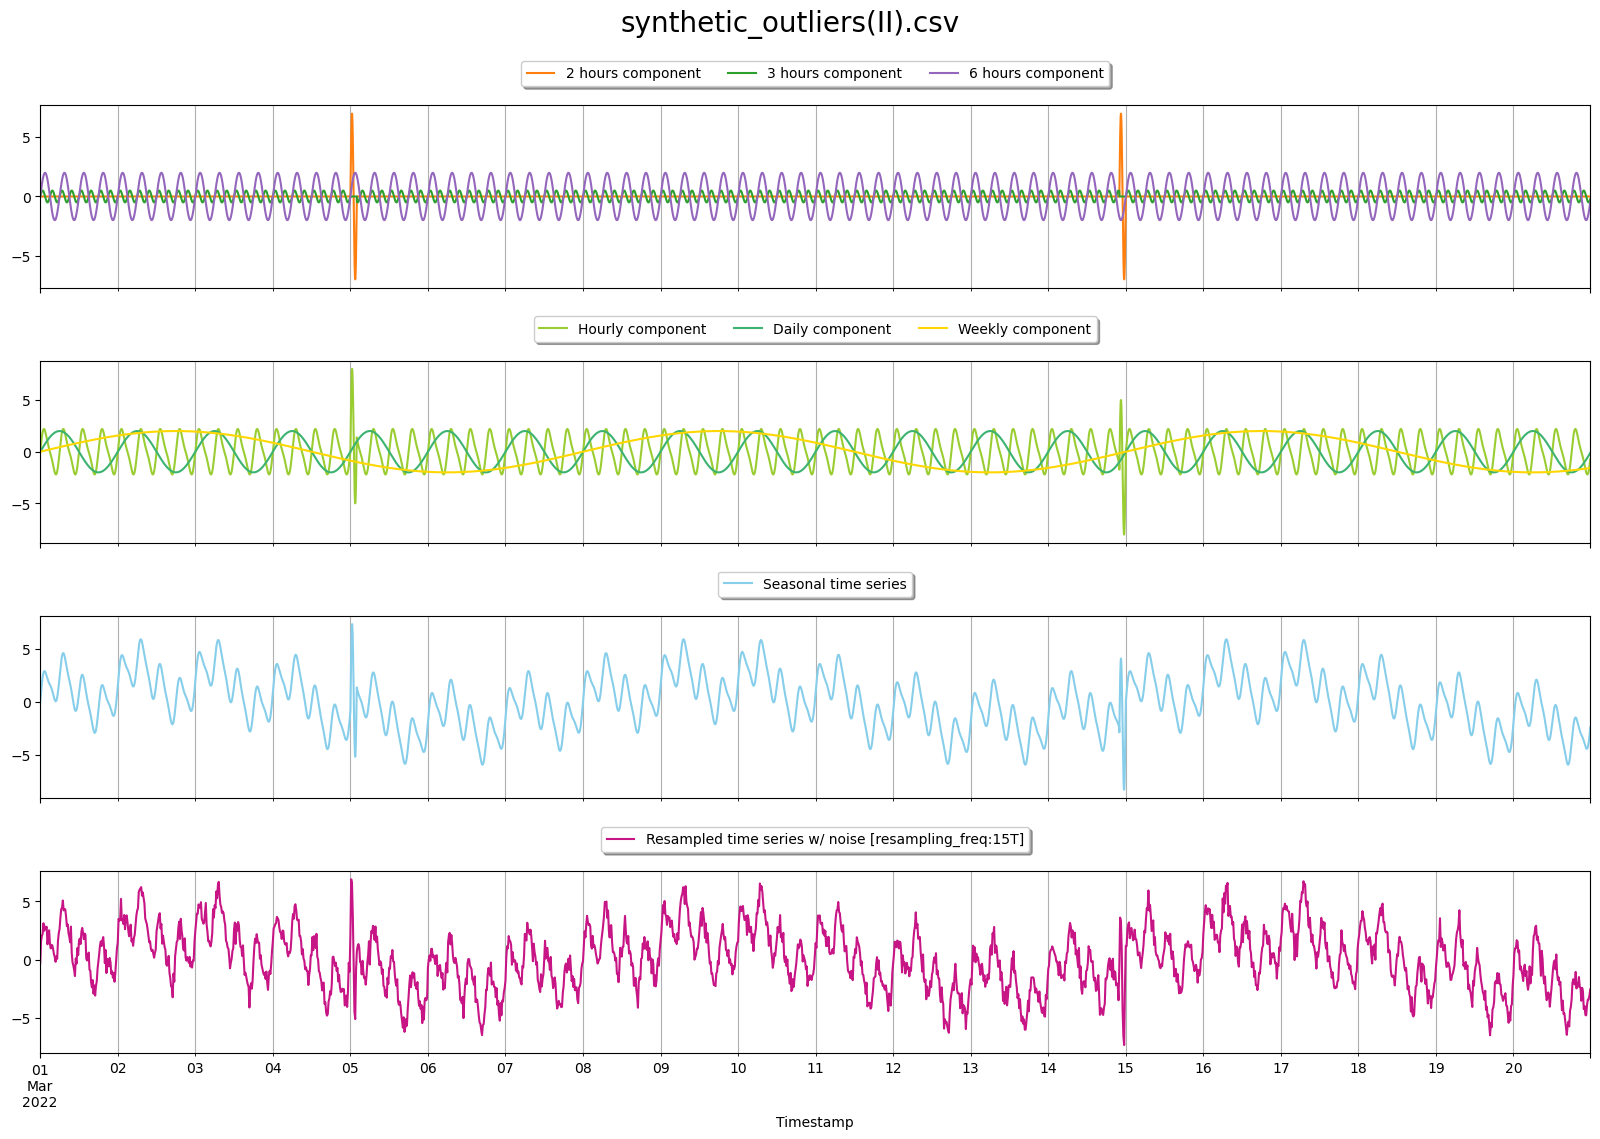

28800

In [25]:
#| export
sd = 2
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*2, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-240, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=2, 
                  weekly_factor=2, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

In [26]:
len(df.columns)

13

### Outliers III

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


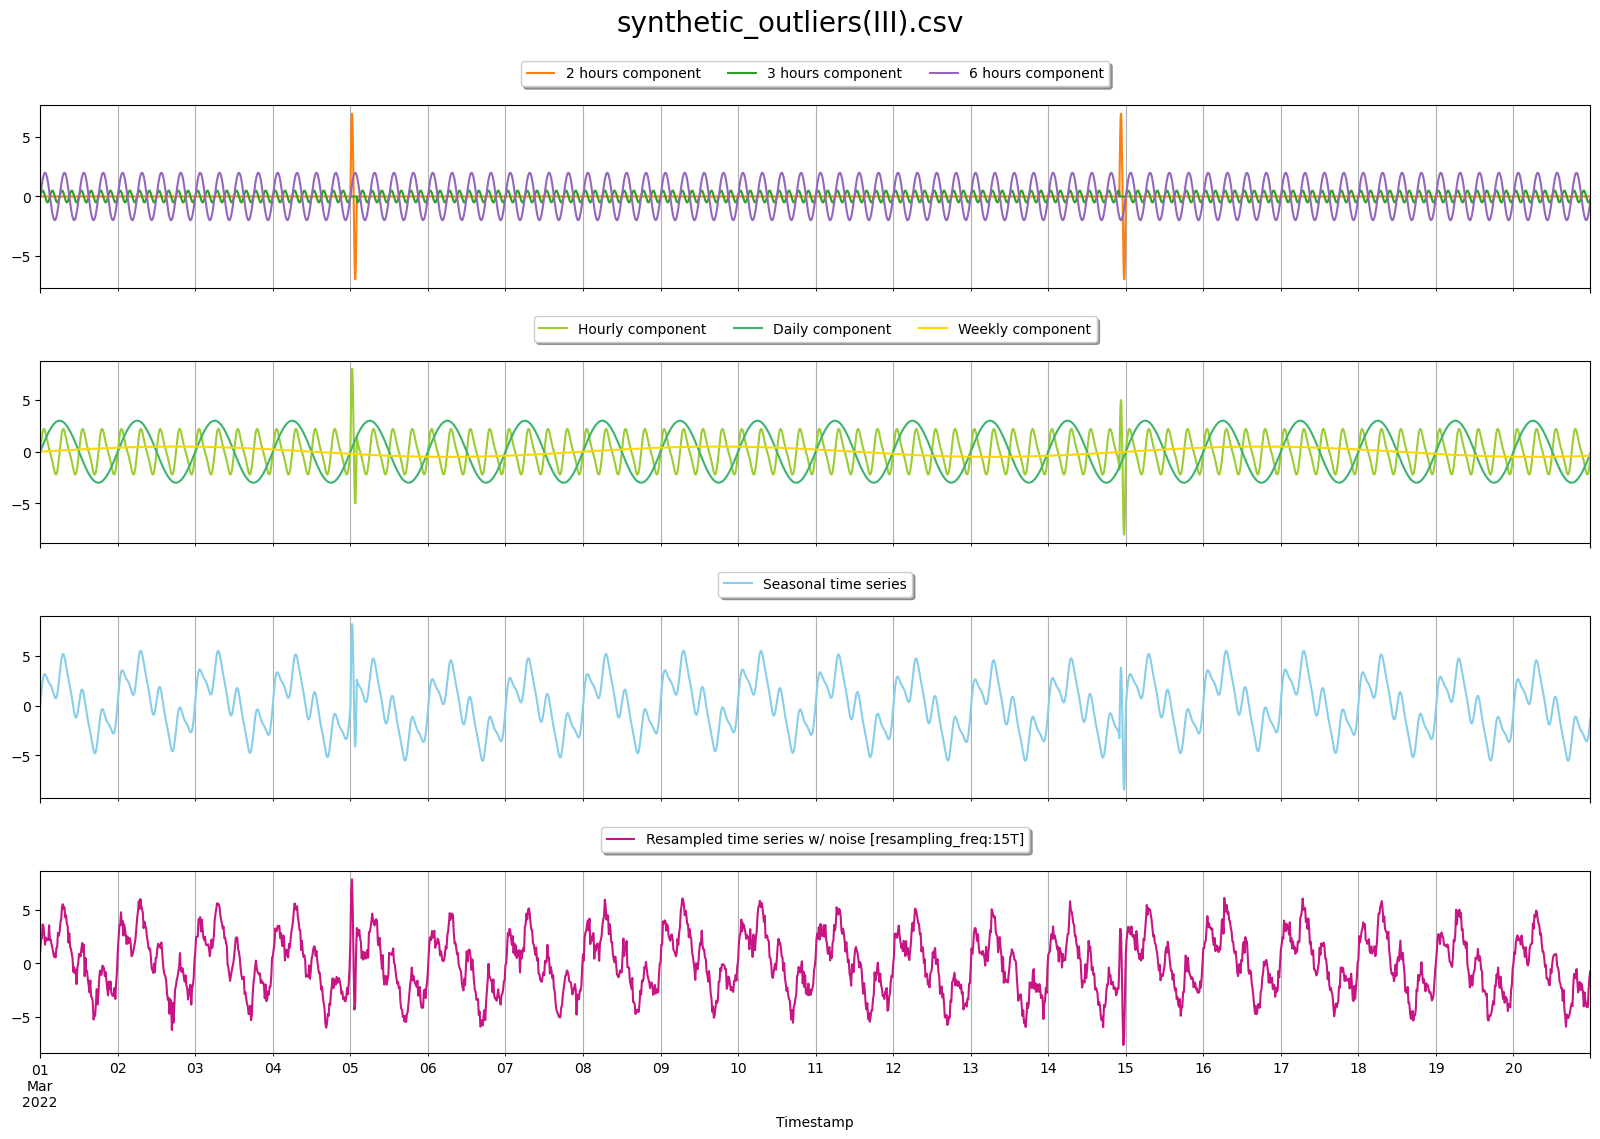

28800

In [27]:
#| export
sd = 2
df1 = generate_ts(periods=60*24*4, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*2, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*24*10-240, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
                  start_date=str(df3.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
                  start_date=str(df4.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3,df4,df5])
time_series_name = 'synthetic_outliers(III).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

In [28]:
len(df.columns)

13

## Synthetic Data - Trends
### Trends I

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


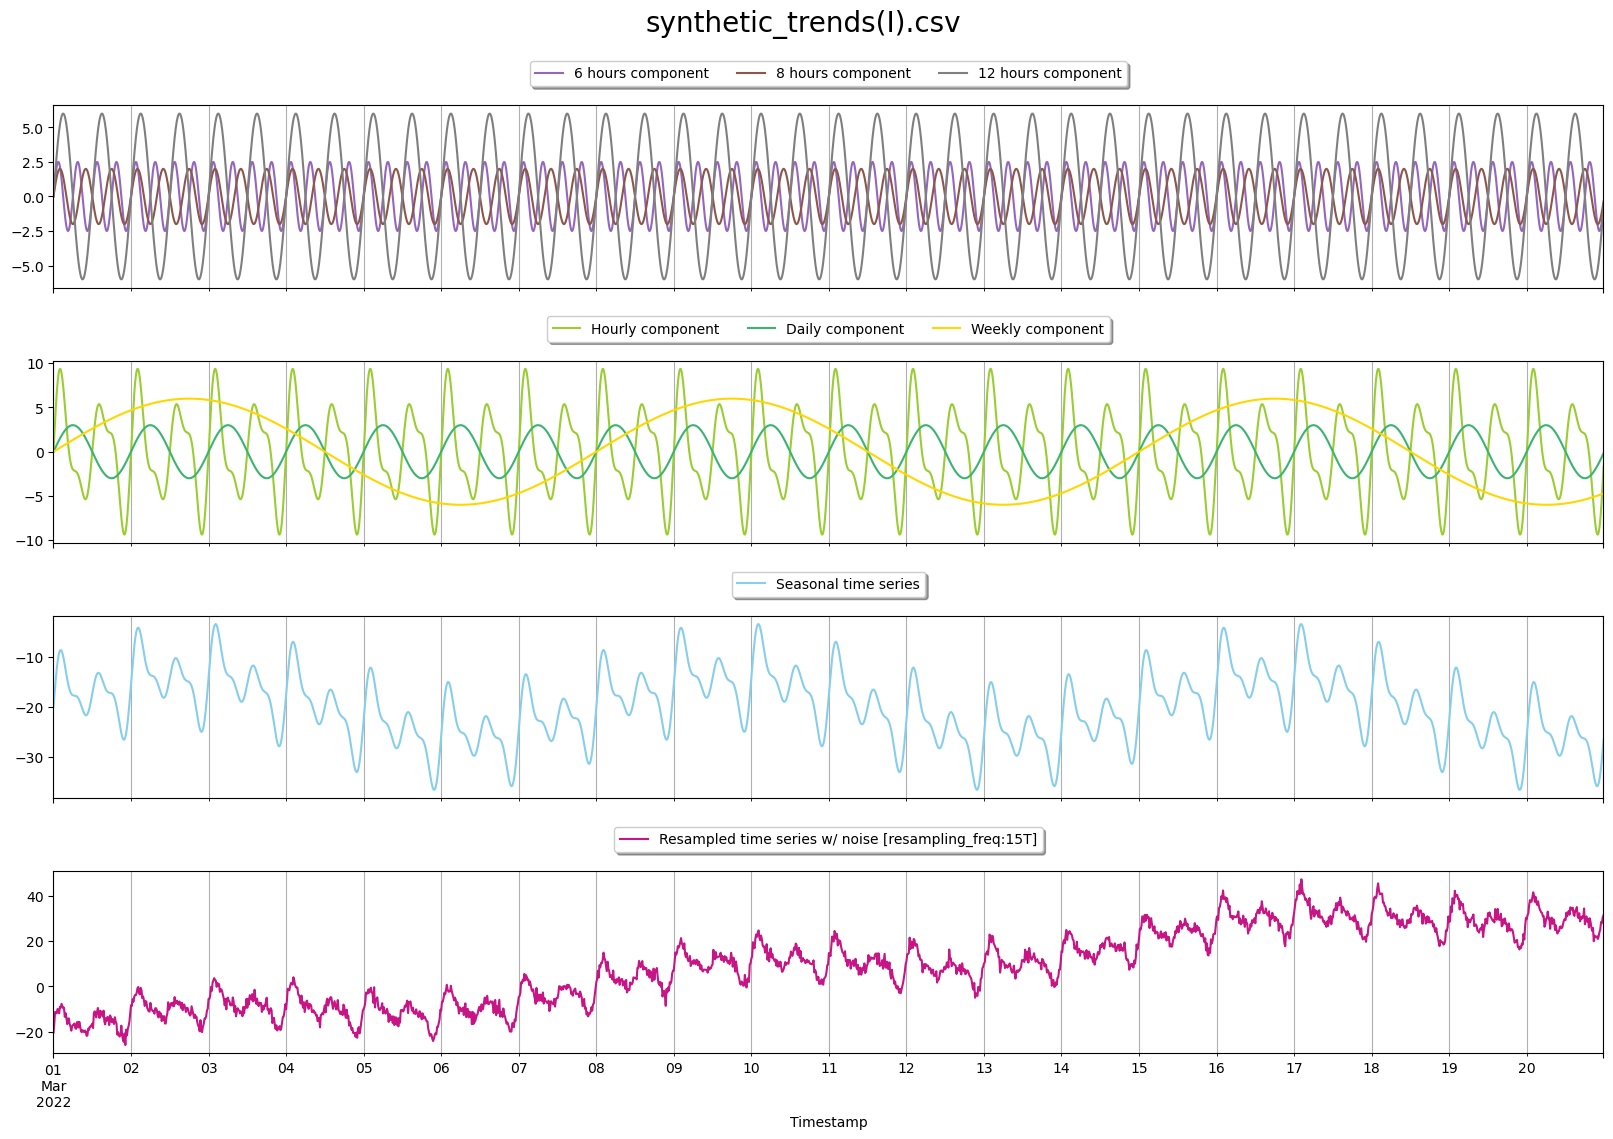

28800

In [29]:
#| export
df1 = generate_ts(periods=60*24*20, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0, 2.5, 2, 6], daily_factor=3, 
                  weekly_factor=6, noise_sd=6, ts_offset=-20, trend=0.002)

df = pd.concat([df1])
time_series_name = 'synthetic_trends(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
len(df)

### Trends II

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


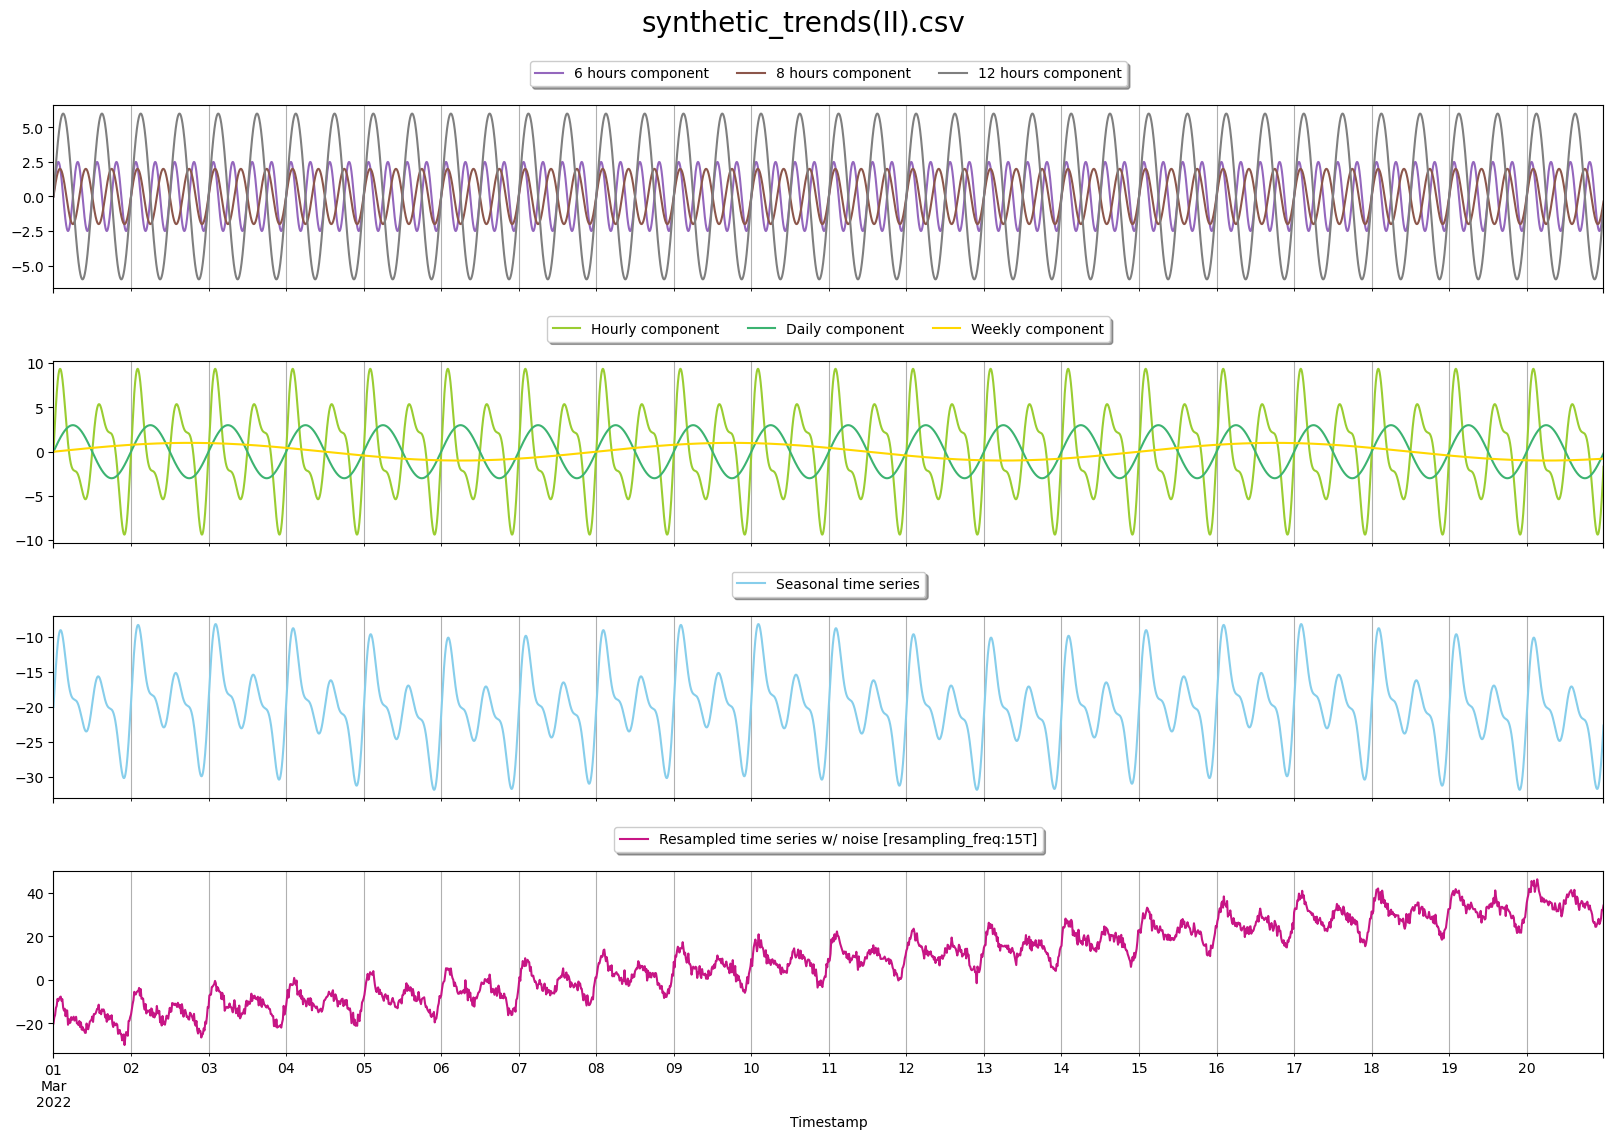

TS: synthetic_trends(II).csv ~ 28800


In [30]:
#| export
df1 = generate_ts(periods=60*24*20, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0, 2.5, 2, 6], daily_factor=3, 
                  weekly_factor=1, noise_sd=6, ts_offset=-20, trend=0.002)

df = pd.concat([df1])
time_series_name = 'synthetic_trends(II).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='15T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
print(f"TS: {time_series_name} ~ {len(df)}")

In [31]:
ndays = 20
ntimesteps = 28800
ntimesteps_day = ntimesteps/ndays
ntimesteps_hour = ntimesteps_day/24
ntimesteps_minutes = ntimesteps_hour/60
print(f"Timesteps:")
print(f"Day: {ntimesteps_day}")
print(f"Hour: {ntimesteps_hour}")
print(f"Minutes: {ntimesteps_minutes}")
print(f"Frequency: 1m")

Timesteps:
Day: 1440.0
Hour: 60.0
Minutes: 1.0
Frequency: 1m


In [32]:
ntimesteps_day = ntimesteps/ndays

/tmp/ipykernel_9097/2682268327.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  h_index = [i for i, (_,y) in enumerate(df.iloc[:,:7].iteritems()) if y.any()]


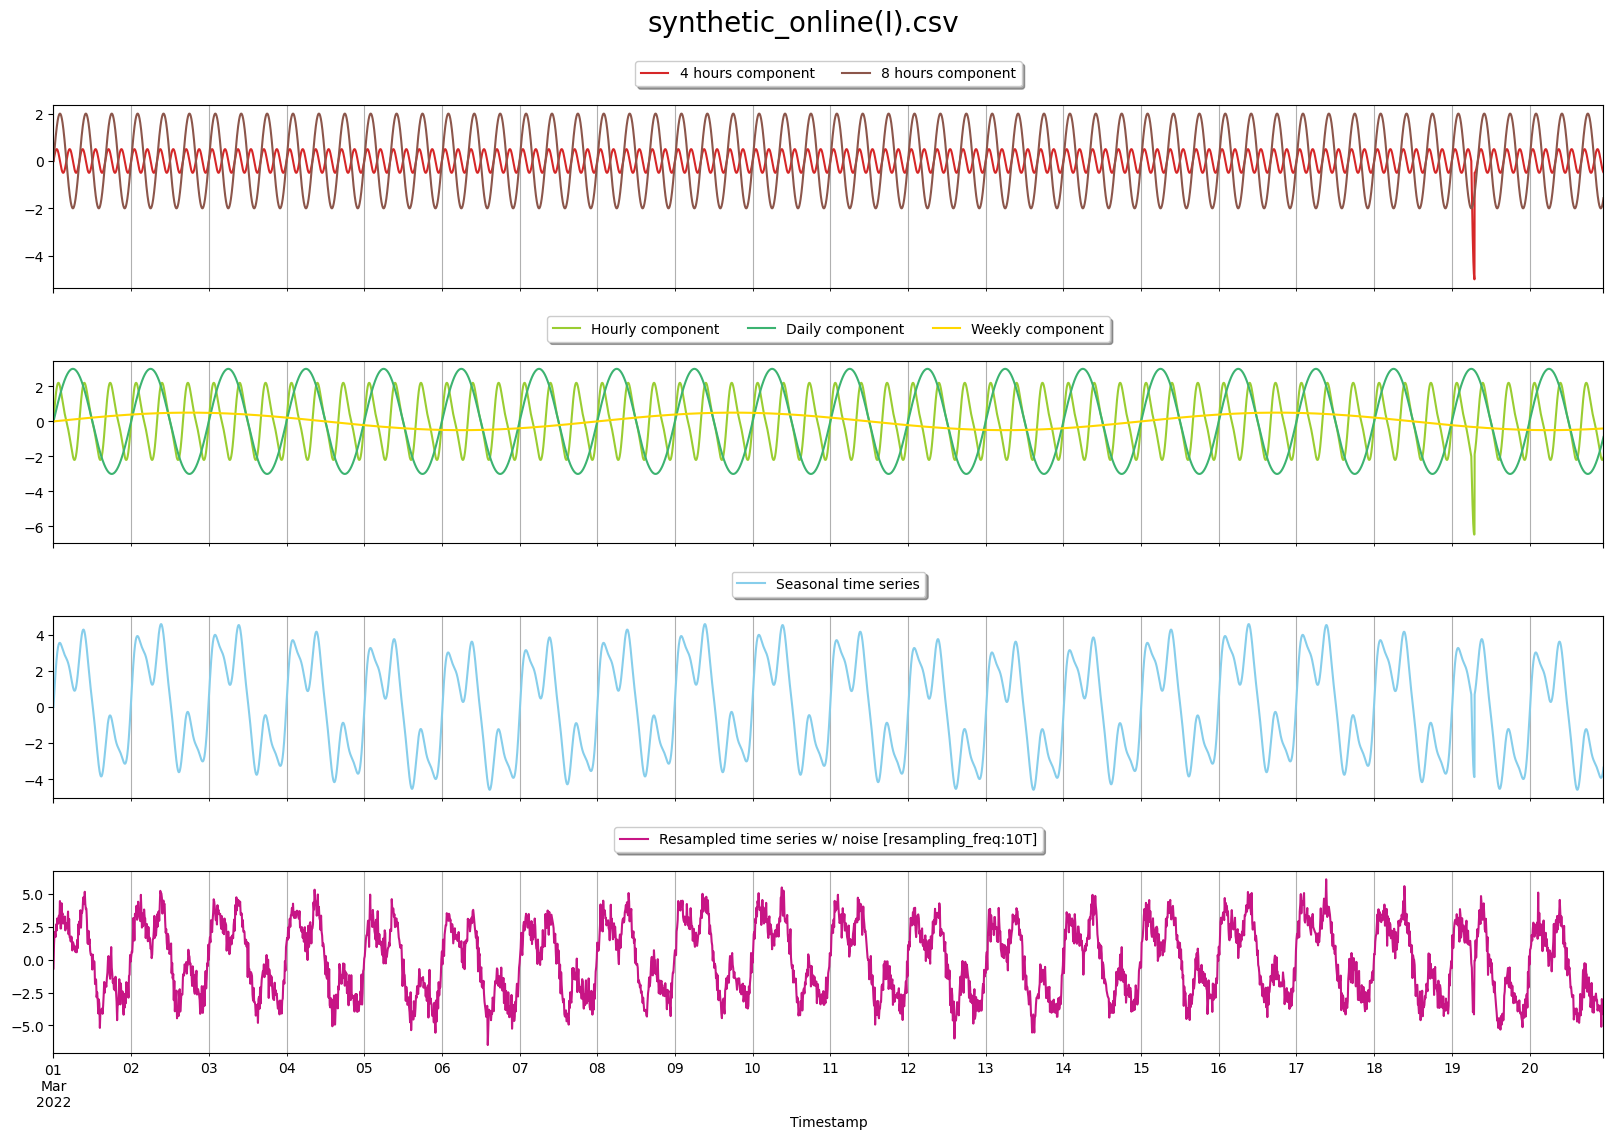

TS: synthetic_online(I).csv: len(df)


In [33]:
#| export
sd = 2
df1 = generate_ts(periods=60*24*18+60*6, start_date='2022-03-01 00:00', index_offset=0,
                  hourly_factors=[0, 0, 0, 0.5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df2 = generate_ts(periods=60*1, index_offset=len(df1),
                  start_date=str(df1.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df3 = generate_ts(periods=60*40, index_offset=len(df1)+len(df2),
                  start_date=str(df2.index[-1] + pd.offsets.Minute()), 
                  hourly_factors=[0, 0, 0, 0.5, 0, 2, 0], daily_factor=3, 
                  weekly_factor=0.5, noise_sd=sd, ts_offset=0)

# df4 = generate_ts(periods=60*2, index_offset=len(df1)+len(df2)+len(df3),
#                   start_date=str(df3.index[-1] + pd.offsets.Minute()), 
#                   hourly_factors=[0, 7, 0, 0, 2, 0, 0], daily_factor=3, 
#                   weekly_factor=0.5, noise_sd=sd, ts_offset=0)

# df5 = generate_ts(periods=60*24*6, index_offset=len(df1)+len(df2)+len(df3)+len(df4),
#                   start_date=str(df4.index[-1] + pd.offsets.Minute()), 
#                   hourly_factors=[0, 0, 0.5, 0, 2, 0, 0], daily_factor=3, 
#                   weekly_factor=0.5, noise_sd=sd, ts_offset=0)

df = pd.concat([df1,df2,df3])
time_series_name = 'synthetic_online(I).csv'
plot_ts_components(df, figsize=(20,12), title=time_series_name, resampling_freq='10T')
df.to_csv(os.path.join(synthetic_data_path, f'{time_series_name}'))
print(f"TS: {time_series_name}: len(df)")

## Synthetic Data - Online
### Online I

In [34]:
#| hide
df.head()

1 hours component  2 hours component  3 hours component  \
Timestamp                                                                      
2022-03-01 00:00:00                0.0                0.0                0.0   
2022-03-01 00:01:00                0.0                0.0                0.0   
2022-03-01 00:02:00                0.0                0.0                0.0   
2022-03-01 00:03:00                0.0                0.0                0.0   
2022-03-01 00:04:00                0.0                0.0                0.0   

                     4 hours component  6 hours component  8 hours component  \
Timestamp                                                                      
2022-03-01 00:00:00           0.000000                0.0           0.000000   
2022-03-01 00:01:00           0.013088                0.0           0.026179   
2022-03-01 00:02:00           0.026168                0.0           0.052354   
2022-03-01 00:03:00           0.039230                0.0           0.078520   
2022-03-01 00:04:00           0.052264                0.0           0.104672   

                     12 hours component  Hourly component  Daily component  \
Timestamp                                                                    
2022-03-01 00:00:00                 0.0          0.000000         0.000000   
2022-03-01 00:01:00                 0.0          0.039268         0.013090   
2022-03-01 00:02:00                 0.0          0.078522         0.026180   
2022-03-01 00:03:00                 0.0          0.117749         0.039269   
2022-03-01 00:04:00                 0.0          0.156936         0.052357   

                     Weekly component     Noise  Seasonal time series  \
Timestamp                                                               
2022-03-01 00:00:00          0.000000 -1.582580              0.000000   
2022-03-01 00:01:00          0.000312  1.040737              0.052669   
2022-03-01 00:02:00          0.000623  0.926356              0.105325   
2022-03-01 00:03:00          0.000935 -2.987842              0.157953   
2022-03-01 00:04:00          0.001247 -4.392839              0.210540   

                     Seasonal time series w/ noise  
Timestamp                                           
2022-03-01 00:00:00                      -1.582580  
2022-03-01 00:01:00                       1.093406  
2022-03-01 00:02:00                       1.031681  
2022-03-01 00:03:00                      -2.829889  
2022-03-01 00:04:00                      -4.182299

In [35]:
df.shape

(28740, 13)